<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/gmm_chooseK_pymc3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian mixture model using PyMC3

Based on https://github.com/aloctavodia/BAP/blob/master/code/Chp6/06_mixture_models.ipynb


In [1]:
try:
    import pymc3 as pm
except ModuleNotFoundError:
    %pip install -qq pymc3
    import pymc3 as pm

import numpy as np
import scipy.stats as stats
import pandas as pd

try:
    import theano.tensor as tt
except ModuleNotFoundError:
    %pip install -qq Theano
    import theano.tensor as tt

import matplotlib.pyplot as plt

try:
    import arviz as az
except ModuleNotFoundError:
    %pip install -qq arviz
    import arviz as az

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, means, p]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 64 seconds.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, means, p]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 62 seconds.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, means, p]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 137 seconds.
The acceptance probability does not match the target. It is 0.8788727262351445, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, means, p]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 239 seconds.
The acceptance probability does not match the target. It is 0.899593512367246, but should be close to 0.8. Try to increase the number of tuning steps.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.583103520212469, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  "The default method used to estimate the weights for each model,"
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_

KeyError: ignored

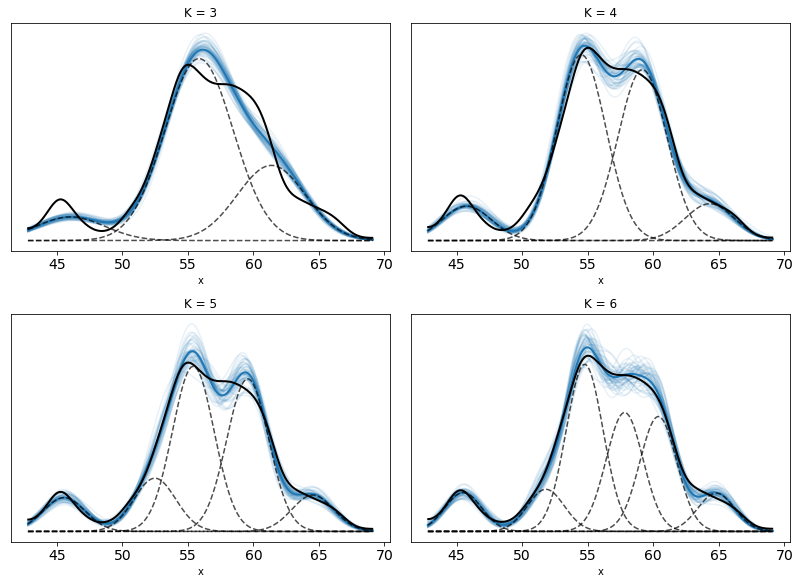

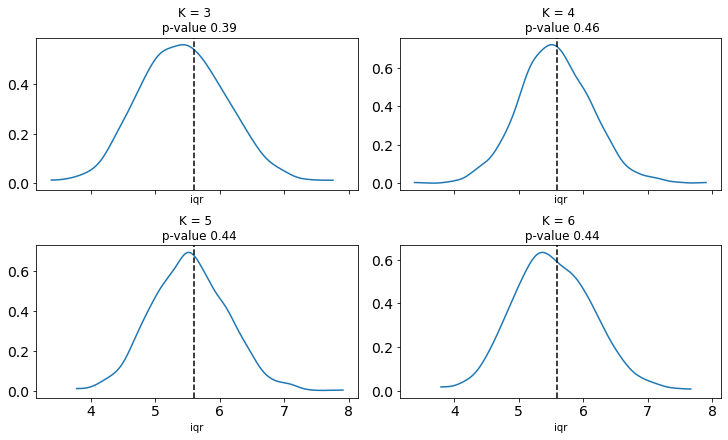

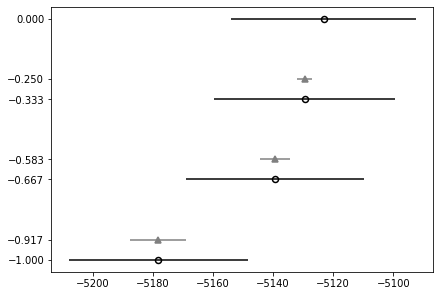

In [3]:
np.random.seed(42)

# url = 'https://github.com/aloctavodia/BAP/tree/master/code/data/chemical_shifts_theo_exp.csv?raw=true'
# There is some error reading the abvoe file
# Error tokenizing data. C error: Expected 1 fields in line 71, saw 2
url = "https://raw.githubusercontent.com/probml/probml-data/main/data/chemical_shifts_theo_exp.csv"
df = pd.read_csv(url, sep=",")
data = df["exp"]

clusters = [3, 4, 5, 6]

models = []
traces = []
for cluster in clusters:
    with pm.Model() as model:
        p = pm.Dirichlet("p", a=np.ones(cluster))
        means = pm.Normal(
            "means",
            mu=np.linspace(data.min(), data.max(), cluster),
            sd=10,
            shape=cluster,
            transform=pm.distributions.transforms.ordered,
        )
        sd = pm.HalfNormal("sd", sd=10)
        y = pm.NormalMixture("y", w=p, mu=means, sd=sd, observed=data)
        trace = pm.sample(1000, tune=2000, random_seed=123, cores=1, chains=2)
        traces.append(trace)
        models.append(model)


# Visualize fitted densities, compared to KDE
_, ax = plt.subplots(2, 2, figsize=(11, 8), constrained_layout=True)

ax = np.ravel(ax)
x = np.linspace(data.min(), data.max(), 200)
for idx, trace_x in enumerate(traces):
    x_ = np.array([x] * clusters[idx]).T

    for i in range(50):  # posterior samples
        i_ = np.random.randint(0, len(trace_x))
        means_y = trace_x["means"][i_]
        p_y = trace_x["p"][i_]
        sd = trace_x["sd"][i_]
        dist = stats.norm(means_y, sd)
        ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y, 1), "C0", alpha=0.1)

    means_y = trace_x["means"].mean(0)
    p_y = trace_x["p"].mean(0)
    sd = trace_x["sd"].mean()
    dist = stats.norm(means_y, sd)
    ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y, 1), "C0", lw=2)
    ax[idx].plot(x, dist.pdf(x_) * p_y, "k--", alpha=0.7)

    az.plot_kde(data, plot_kwargs={"linewidth": 2, "color": "k"}, ax=ax[idx])
    ax[idx].set_title("K = {}".format(clusters[idx]))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel("x")
plt.savefig("gmm_chooseK_pymc3_kde.pdf")
plt.show()

In [ ]:
# Posteroior predictive check

nclusters = len(clusters)
ppc_mm = [pm.sample_posterior_predictive(traces[i], 1000, models[i]) for i in range(nclusters)]

fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True, constrained_layout=True)
ax = np.ravel(ax)


def iqr(x, a=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))


T_obs = iqr(data)
for idx, d_sim in enumerate(ppc_mm):
    T_sim = iqr(d_sim["y"][:100].T, 1)
    p_value = np.mean(T_sim >= T_obs)
    az.plot_kde(T_sim, ax=ax[idx])
    ax[idx].axvline(T_obs, 0, 1, color="k", ls="--")
    ax[idx].set_title(f"K = {clusters[idx]} \n p-value {p_value:.2f}")
    # ax[idx].set_yticks([])
    ax[idx].set_xlabel("iqr")

plt.savefig("gmm_chooseK_pymc3_pval.pdf")
plt.show()

In [ ]:
# Compute information criteria for the 4 models
# Use Bayesian Bootstrapping together with
# pseudo Bayes Model Averaging
# See "Bayesian analysis with Python" p201
comp = az.compare(dict(zip(clusters, traces)), method="BB-pseudo-BMA")
comp
az.plot_compare(comp)
plt.savefig("gmm_chooseK_pymc3_waic.pdf")